In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
import os
import folium
import json
import seaborn as sns
warnings.filterwarnings('ignore')

In [3]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.utils import resample

We load the data into a Pandas dataframe. A row of our dataframe will look as follows:

| CountryName| Country |  IndicatorName | Indicator  | Units | Scale | Frequency | Date | Value
| :----:|:-------------:| :-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
| Tunisia | TUN | Inflation, consumer prices (annual %) | FP.CPI.TOTL.ZG | 	annual % | 1 | A | 1980-01-01 | 6.1

Our data contains thus several socio-economic indicators for the african countries 

Loading the data and doing some basic preprocessing

In [4]:
DATA_PATH = "data/"
AFDB_2019 = "Data.csv"
initial_data = pd.read_csv(DATA_PATH + AFDB_2019, sep=',')

#the drop didn't change the shape of our dataset
initial_data.dropna(subset=['Date', 'Value','Country','Indicator'],inplace = True) 

#retrieving only the year from the date column
initial_data.Date = initial_data.Date.apply(lambda x : x.split("-")[0]).astype(int)
initial_data.rename(columns = {'Date':'Year'}, inplace = True)
initial_data.Scale = initial_data.Scale.astype(int)
#initial_data.Value = initial_data.Value.astype(float)
initial_data.head()

,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
0,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2000,9.133374
1,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2001,8.535367
2,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2002,7.238168
3,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2003,7.217622
4,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2004,7.373657


Loading the indicators data that contains the name and the code for all the indicators present in our initial dataset 

In [5]:
INDICATORS = "Indicator.csv"
indicators_data = pd.read_csv(DATA_PATH + INDICATORS, sep=',')
indicators_data = indicators_data[['Order','Name','Code']]
indicators_data.head()

,Order,Name,Code
0,1,Prices,KN.B1
1,2,"Inflation, consumer prices index (2000 = 100)",FP.CPI.TOTL
2,3,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG
3,4,"Consumer Price Index, in Clothing and Footwear...",CTRY.FP.CPI.CLF
4,5,"Consumer Price Index, in Communication (% change)",CTRY.FP.CPI.COM


In [6]:
all_years = np.sort(initial_data.Year.unique())
all_years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025,
       2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036,
       2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047,
       2048, 2049, 2050])

We can see that we have data from 1960 till 2050 in our initial dataset we will just pick up the data from 1960 to 2019

In [7]:
initial_data = initial_data[initial_data.Year < 2020]

In [8]:
indicators_by_year = pd.pivot_table(initial_data, values='Value', index=['Country','Year'], columns=['Indicator'])
indicators_by_year

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
ADB     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZZM     2015                NaN                NaN                NaN   
        2016                NaN                NaN                NaN   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
ADB     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZZM     2015             NaN                 NaN                 NaN   
        2016             NaN                 NaN                 NaN   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
ADB     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZZM     2015          NaN                   NaN                    NaN   
        2016          NaN                   NaN                    NaN   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
ADB     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZZM     2015                   NaN  ...                NaN              NaN   
        2016                   NaN  ...                NaN              NaN   
        2017                   NaN  ...                NaN              NaN   
        2018                   NaN  ...                NaN              NaN   
        2019                   NaN  ...                NaN              NaN   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

We see that in our initial dataframe we don't have only countries but also some data for regions(regrouped countries), and also for the entire continent we suppose that it is an estimation for the average values of all the countries indicators. We also observe that we have in `indicators_by_year` many missing values essentially in the first years when looking deeper into the dataset so we will retrieve only the countries plus the african data for further alysis and analyse the occurence of this missing values to know how to deal with them 

In [9]:
# array of the African countries name plus the African continent 
Countries_Only = ['AFRICA','Cameroon', 'Central African Republic','Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea',
                 'Gabon', 'Sao Tome and Principe', 'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia','Kenya',
                 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Algeria', 'Egypt',
                 'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Angola', 'Botswana', 'Lesotho', 'Madagascar', 'Malawi',
                 'Mauritius', 'Mozambique', 'Namibia', 'South Africa', 'Swaziland', 'Zambia', 'Zimbabwe', 'Benin',
                 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia',
                 'Mali', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone','Togo']

In [10]:
missing_dates = initial_data[['CountryName','Country','Year','Indicator','Value']]
missing_dates = missing_dates[missing_dates.CountryName.isin(Countries_Only)]
missing_dates['Value'].replace(0, np.nan, inplace=True)
missing_dates['MissingValues'] = missing_dates.isnull().sum(axis = 1)
missing_dates = missing_dates[['Year','MissingValues']].groupby(['Year']).sum()
missing_dates = missing_dates.reset_index() 

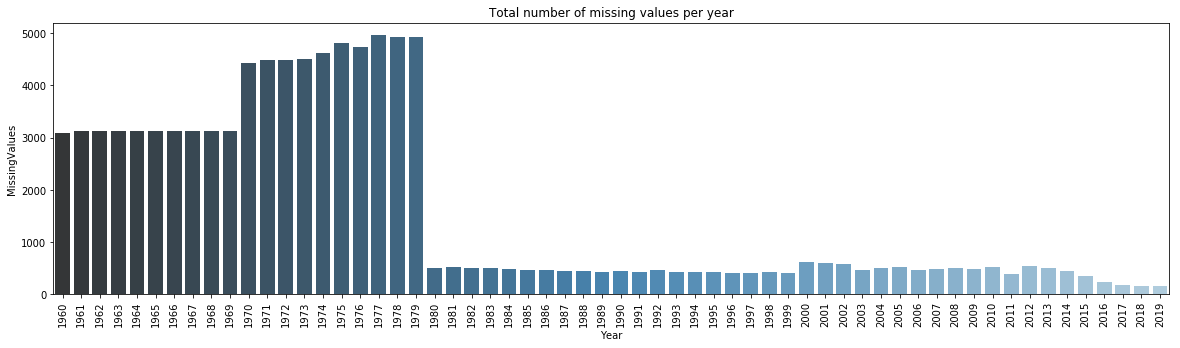

In [11]:
plt.figure(figsize=(20,5))
pl = sns.barplot(missing_dates.Year, y=missing_dates.MissingValues, palette="Blues_d")
pl.set_xticklabels(missing_dates.Year,rotation=90)
pl.set_title('Total number of missing values per year')
plt.show()

In [12]:
ind_by_year = initial_data[['CountryName','Country','Year','Indicator','Value']]
ind_by_year = ind_by_year[ind_by_year.CountryName.isin(Countries_Only)]

ind_by_year = ind_by_year[['Year','Indicator']].groupby(['Year']).count()
ind_by_year = ind_by_year.reset_index() 

In [13]:
len(Countries_Only)

55

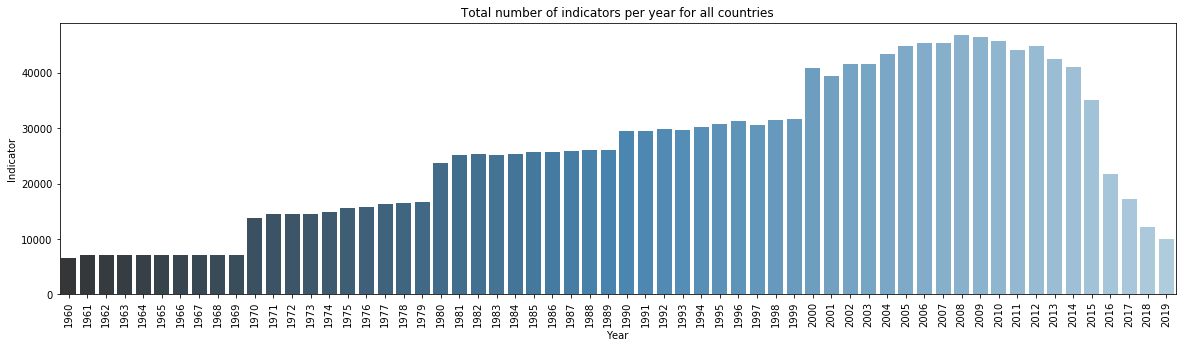

In [14]:
plt.figure(figsize=(20,5))
pl = sns.barplot(ind_by_year.Year, y=ind_by_year.Indicator, palette="Blues_d")
pl.set_xticklabels(ind_by_year.Year,rotation=90)
pl.set_title('Total number of indicators per year for all countries')
plt.show()

In [15]:
percentage_missing = missing_dates.set_index('Year').join(ind_by_year.set_index('Year'))
percentage_missing['Percentage'] = round(percentage_missing['MissingValues'] / percentage_missing['Indicator'] * 100,2)

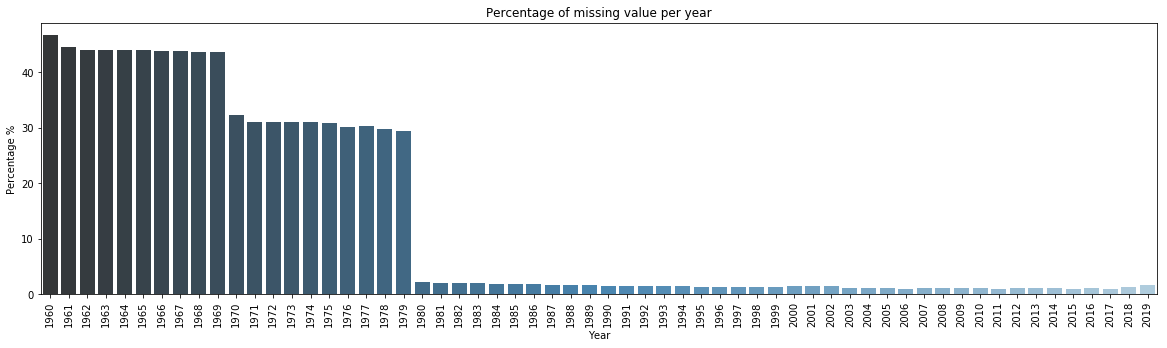

In [16]:
plt.figure(figsize=(20,5))
pl = sns.barplot(percentage_missing.index, y=percentage_missing.Percentage, palette="Blues_d")
pl.set_xticklabels(percentage_missing.index,rotation=90)
pl.set_title('Percentage of missing value per year')
pl.set_ylabel('Percentage %')
plt.show()

In [17]:
countries_data = initial_data[initial_data.CountryName.isin(Countries_Only)]
indicators_country_year = pd.pivot_table(countries_data, values='Value', index=['Country','Year'], columns=['Indicator'])
indicators_country_year

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AFR     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AFR     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015             NaN                 2.7                2.50   
        2016             NaN                 2.7                2.75   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AFR     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015          NaN               3.33333                2.16667   
        2016          NaN               3.66667                2.16667   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AFR     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   NaN  ...       1.263811e+09       302.366614   
        2018                   NaN  ...       1.331340e+09       299.264516   
        2019                   NaN  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

In [18]:
indicators_country_year['Count'] = indicators_country_year.apply(lambda x: x.count(), axis=1)
indicators_country_year['Count']
indicators_by_country = indicators_country_year['Count']

In [19]:
indicators_by_country_np = indicators_by_country.to_numpy()
indicators_by_country_np = indicators_by_country_np.reshape((55,60))

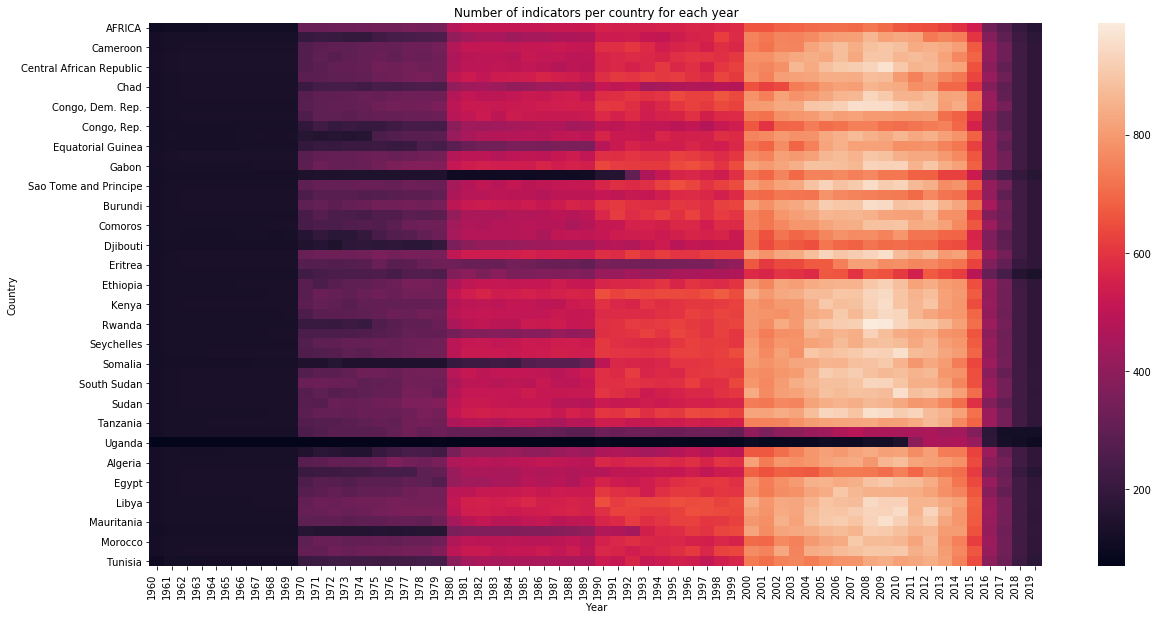

In [20]:
plt.subplots(figsize=(20,10))
x_ticks = np.arange(1960,2020)
y_ticks = Countries_Only
heatmap = sns.heatmap(indicators_by_country_np)
heatmap.set_xticklabels(x_ticks, rotation=90, horizontalalignment='right')
heatmap.set_yticklabels(y_ticks, rotation=0, horizontalalignment='right')
heatmap.set_xlabel('Year')
heatmap.set_ylabel('Country')
heatmap.set_title('Number of indicators per country for each year')
plt.show()

In [21]:
def lowercase_all(text):
    return text.lower()

In [22]:
education_keywords = ['education','literacy','enrol','school','teach','pupil','stud','repeat',
                      'test','search','grade','intern','knowledge','lab','read','prof','write','report','skill']

'''
['university','department','degree','learn','college','academic','assessment','class','course','curriculum','exam',
'faculty','instruct','intellect','language','quizz', ..etc] 
These keywords and many others didn't add a single row to the result, Hence we discarded them.
We have chosen these keywords based on the data examined manually to look a bit what we are dealing with, and from well known
education related dictionaries.
'''

inds_education = indicators_data[indicators_data.Name.apply(lowercase_all).str.contains('|'.join(education_keywords))]
inds_education

,Order,Name,Code
31,32,Internet users per 100 inhabitants,IT.NET.USER.P3
32,33,Proportion of individuals using the Internet,IT.USE.ii99
42,43,Internet users,IT.NET.USER
43,44,Internet Subscribers,IT.NET.SCRB
46,47,Fixed Internet broadband Subscriptions per 100...,IT.NET.BBND
...,...,...,...
1637,1638,Teaching staff at third level - Total (number),CTRY.SE.TCHR.THIRD
1638,1639,Third level student enrollment - Female (number),CTRY.SE.TER.ENRR.FE.TOT
1639,1640,Third level student enrollment - Total (number),CTRY.SE.TER.ENRR.TOT
1640,1641,Public expenditure on education (% of budget),CTRY.SE.XPD.BUDG.ZS


In [23]:
education_codes = inds_education.Code.unique().tolist()
db_education = countries_data[countries_data.Indicator.str.match('|'.join(education_codes))]
db_education

,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
399,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1991,0.000737
400,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1992,0.002143
401,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1993,0.006324
402,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1994,0.014261
403,AFRICA,AFR,Internet users per 100 inhabitants,IT.NET.USER.P3,per 100 inhabitants,1,A,1995,0.040432
...,...,...,...,...,...,...,...,...,...
2790080,Sierra Leone,SLE,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2006,10.000000
2790081,Sierra Leone,SLE,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2007,10.000000
2790089,Togo,TGO,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2005,25.000000
2790090,Togo,TGO,Employing Workers - Nonwage labor cost (% of s...,PS.DB.EW.NW.LC.IN,% of salary,1,A,2006,25.000000


In [24]:
db_ed = pd.pivot_table(db_education, values='Value', index=['Country', 'Year'], columns=['Indicator'])

#thresh=N requires that a column has at least N non-NaNs to survive
#We chose to work with an indicator if at least half of its values are not missing.

th = 0.5
print(db_ed.shape)
db_ed.dropna(axis=1,thresh=int(th*db_ed.shape[0]),inplace=True)
print(db_ed.shape)

(3281, 161)
(3281, 27)


Now it's time to check manually the description of the 28 selected attributes (indicators) to see if they are really
education-related, hence relevant for our study, or not.
Because until now the only filter we have done is selecting indicators with description containing one of those 
education-related keywords from above.

In [25]:
inds_educ_after_nan_codes = indicators_data[indicators_data.Code.str.match('|'.join(db_ed.columns))]
#inds_educ_after_nan_codes = inds_educ_after_nan_codes[['Code','Name','Source_Note']]
inds_educ_after_nan_codes = inds_educ_after_nan_codes[['Code','Name']]
inds_educ_after_nan_codes

,Code,Name
236,AG.POP.EAC.TOT.ZS,Labour force participation (as % of total)
383,PA.NUS.PPP,Purchasing power parity conversion factor (LCU...
418,NY.GDP.PCAP.PP.CD,"GDP Per capita, PPP (current international $)"
1242,FI.RES.TOTL.MO,Gross international reserves in months of imports
1243,FI.RES.TOTL.CD,Gross international reserves (current US$)
1287,SE.ENR.PRIM.FM.ZS,Ratio of female to male primary enrollment
1289,SE.PRM.ENRL.TC.ZS,"Pupil-teacher ratio, primary"
1290,SE.PRM.ENRR,"School enrollment, primary (% gross)"
1291,SE.PRM.ENRR.FE,"School enrollment, primary, female (% gross)"
1292,SE.PRM.ENRR.MA,"School enrollment, primary, male (% gross)"


We see that the first 4 shown indicators, which are:

AG.POP.EAC.TOT.ZS   -    Labour force participation (as % of total)

NY.GDP.PCAP.PP.CD   -    GDP Per capita, PPP (current international D)

FI.RES.TOTL.MO      -    Gross international reserves in months of imports

FI.RES.TOTL.CD      -    Gross international reserves (current USD)

These have nothing to do with what we are looking for, they were only present because of the keywords : "lab" for the first
indicator when looking for potential description including a laboratory, and "intern" for the 3 others when looking 
for potential description including an intern student or an internship ..

Hence we can exclude these 4 indicators.

In [26]:
print(db_ed.shape)
db_ed = db_ed.drop(columns=['AG.POP.EAC.TOT.ZS','NY.GDP.PCAP.PP.CD','FI.RES.TOTL.MO','FI.RES.TOTL.CD'])
db_ed.shape

(3281, 27)


(3281, 23)

### Correlation plots between the education attributes

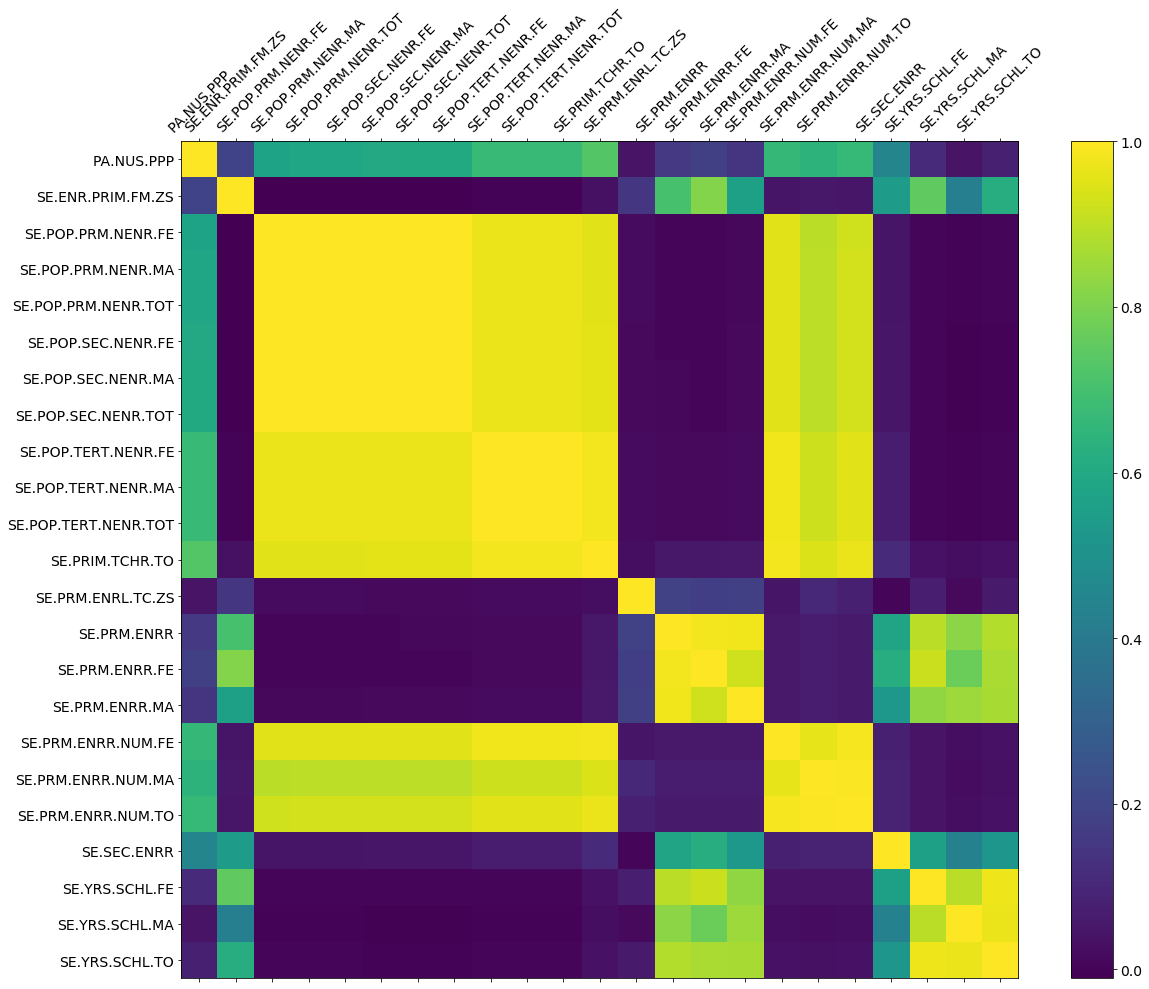

In [27]:
f = plt.figure(figsize=(19, 15))
plt.matshow(db_ed.corr(), fignum=f.number)
plt.xticks(range(db_ed.shape[1]), db_ed.columns, fontsize=14, rotation=45)
plt.yticks(range(db_ed.shape[1]), db_ed.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [28]:
corr = db_ed.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

Indicator,PA.NUS.PPP,SE.ENR.PRIM.FM.ZS,SE.POP.PRM.NENR.FE,SE.POP.PRM.NENR.MA,SE.POP.PRM.NENR.TOT,SE.POP.SEC.NENR.FE,SE.POP.SEC.NENR.MA,SE.POP.SEC.NENR.TOT,SE.POP.TERT.NENR.FE,SE.POP.TERT.NENR.MA,SE.POP.TERT.NENR.TOT,SE.PRIM.TCHR.TO,SE.PRM.ENRL.TC.ZS,SE.PRM.ENRR,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.PRM.ENRR.NUM.FE,SE.PRM.ENRR.NUM.MA,SE.PRM.ENRR.NUM.TO,SE.SEC.ENRR,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA,SE.YRS.SCHL.TO
Indicator,,,,,,,,,,,,,,,,,,,,,,,
PA.NUS.PPP,1,0.192,0.575,0.588,0.582,0.598,0.605,0.601,0.673,0.675,0.674,0.73,0.0432,0.157,0.179,0.143,0.661,0.644,0.665,0.449,0.109,0.0442,0.0798
SE.ENR.PRIM.FM.ZS,0.192,1,-0.0086,-0.00776,-0.00817,-0.0108,-0.01,-0.0104,-0.000182,0.00065,0.000235,0.0328,0.149,0.708,0.811,0.562,0.0445,0.0551,0.0507,0.549,0.755,0.426,0.62
SE.POP.PRM.NENR.FE,0.575,-0.0086,1,1,1,0.999,0.999,0.999,0.969,0.969,0.969,0.955,0.0179,0.0072,0.00666,0.0105,0.954,0.897,0.929,0.0454,0.00753,-0.00111,0.0032
SE.POP.PRM.NENR.MA,0.588,-0.00776,1,1,1,0.999,0.999,0.999,0.969,0.969,0.969,0.956,0.0179,0.00769,0.00727,0.0109,0.955,0.898,0.93,0.0476,0.00772,-0.00119,0.0033
SE.POP.PRM.NENR.TOT,0.582,-0.00817,1,1,1,0.999,0.999,0.999,0.969,0.969,0.969,0.956,0.0179,0.00745,0.00697,0.0107,0.955,0.898,0.929,0.0465,0.00763,-0.00115,0.00325
SE.POP.SEC.NENR.FE,0.598,-0.0108,0.999,0.999,0.999,1,1,1,0.972,0.971,0.972,0.958,0.0157,0.00887,0.00765,0.0131,0.955,0.898,0.93,0.0502,0.00459,-0.00333,0.000608
SE.POP.SEC.NENR.MA,0.605,-0.01,0.999,0.999,0.999,1,1,1,0.971,0.971,0.971,0.958,0.0154,0.00948,0.00833,0.0137,0.956,0.899,0.93,0.0523,0.00487,-0.00326,0.000824
SE.POP.SEC.NENR.TOT,0.601,-0.0104,0.999,0.999,0.999,1,1,1,0.972,0.971,0.971,0.958,0.0155,0.00918,0.00799,0.0134,0.955,0.898,0.93,0.0512,0.00473,-0.0033,0.000717
SE.POP.TERT.NENR.FE,0.673,-0.000182,0.969,0.969,0.969,0.972,0.971,0.972,1,1,1,0.981,0.0183,0.0146,0.015,0.0173,0.978,0.923,0.954,0.0652,0.00772,-0.0021,0.00277


In [29]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['SE.POP.PRM.NENR.MA',
 'SE.POP.PRM.NENR.TOT',
 'SE.POP.SEC.NENR.FE',
 'SE.POP.SEC.NENR.MA',
 'SE.POP.SEC.NENR.TOT',
 'SE.POP.TERT.NENR.FE',
 'SE.POP.TERT.NENR.MA',
 'SE.POP.TERT.NENR.TOT',
 'SE.PRIM.TCHR.TO',
 'SE.PRM.ENRR.FE',
 'SE.PRM.ENRR.MA',
 'SE.PRM.ENRR.NUM.FE',
 'SE.PRM.ENRR.NUM.MA',
 'SE.PRM.ENRR.NUM.TO',
 'SE.YRS.SCHL.TO']

In [30]:
to_keep = [element for element in upper.columns if element not in to_drop]
db_keep = db_ed[to_keep]
print(db_keep.shape)
to_keep

(3281, 8)


['PA.NUS.PPP',
 'SE.ENR.PRIM.FM.ZS',
 'SE.POP.PRM.NENR.FE',
 'SE.PRM.ENRL.TC.ZS',
 'SE.PRM.ENRR',
 'SE.SEC.ENRR',
 'SE.YRS.SCHL.FE',
 'SE.YRS.SCHL.MA']

What we're doing here is just replacing the School age population Primary-Female (SE.POP.PRM.NENR.FE) with the School 
age population Primary-Total and The Primary school teachers-Female (SE.PRIM.TCHR.FE) with the Enrolment in total 
primary-Total. (These are very correlated, we just did the replacement for name convenience, won't affect our findings)

In [31]:
to_keep = pd.Series(to_keep).replace(['SE.POP.PRM.NENR.FE', 'SE.PRIM.TCHR.FE'],
                                     ['SE.POP.PRM.NENR.TOT', 'SE.PRM.ENRR.NUM.TO']).tolist()
to_keep

['PA.NUS.PPP',
 'SE.ENR.PRIM.FM.ZS',
 'SE.POP.PRM.NENR.TOT',
 'SE.PRM.ENRL.TC.ZS',
 'SE.PRM.ENRR',
 'SE.SEC.ENRR',
 'SE.YRS.SCHL.FE',
 'SE.YRS.SCHL.MA']

### Final correlation Matrix

In [32]:
db_final_ed = db_ed[to_keep]
corr_keep = db_final_ed.corr()
corr_keep.style.background_gradient(cmap='coolwarm').set_precision(3)

Indicator,PA.NUS.PPP,SE.ENR.PRIM.FM.ZS,SE.POP.PRM.NENR.TOT,SE.PRM.ENRL.TC.ZS,SE.PRM.ENRR,SE.SEC.ENRR,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA
Indicator,,,,,,,,
PA.NUS.PPP,1,0.192,0.582,0.0432,0.157,0.449,0.109,0.0442
SE.ENR.PRIM.FM.ZS,0.192,1,-0.00817,0.149,0.708,0.549,0.755,0.426
SE.POP.PRM.NENR.TOT,0.582,-0.00817,1,0.0179,0.00745,0.0465,0.00763,-0.00115
SE.PRM.ENRL.TC.ZS,0.0432,0.149,0.0179,1,0.186,0.00272,0.0726,0.0139
SE.PRM.ENRR,0.157,0.708,0.00745,0.186,1,0.578,0.896,0.825
SE.SEC.ENRR,0.449,0.549,0.0465,0.00272,0.578,1,0.562,0.433
SE.YRS.SCHL.FE,0.109,0.755,0.00763,0.0726,0.896,0.562,1,0.895
SE.YRS.SCHL.MA,0.0442,0.426,-0.00115,0.0139,0.825,0.433,0.895,1


We conclude our final Education related attributes that we're gonna work with:


1. SE.POP.PRM.NENR.TOT - School age population Primary Total 

From correlation observations, this also represents the School age population for Secondary and Tertiaty.


2. SE.PRM.ENRR.NUM.TO  - Enrollment in total primary, Total

From correlation observations, this also represents the Enrollment in total for Secondary School as well as the number
of (primary) school teachers.


3. SE.PRM.ENRL.TC.ZS   - Pupil-teacher ratio, primary

4. SE.PRM.ENRR         - School enrollment, primary (% gross)

5. SE.YRS.SCHL.FE      - School Life Expectancy - Female (years)

6. SE.YRS.SCHL.MA      - School Life Expectancy - Male (years)


We let the School life expectancy for Females and Males separated because we found out they are not very correlated
and hence can lead us to good/unexpected results.

Text(0.5,1,'School Life Expectancy (Male)')

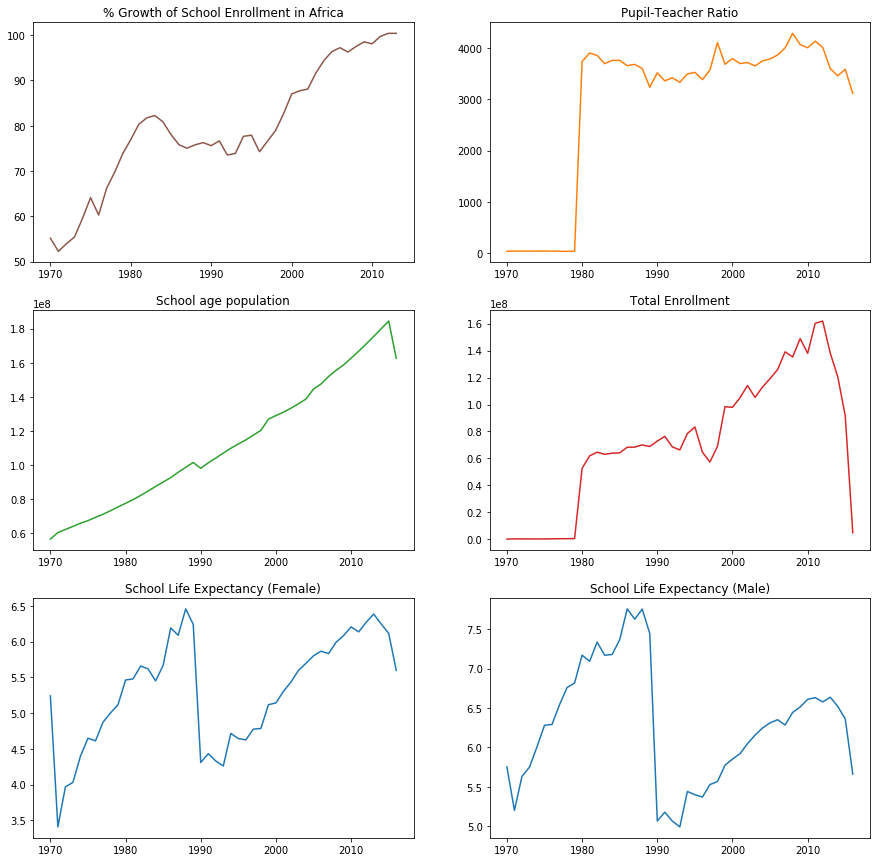

In [33]:
#Plots of chosen variables:

db_afr_indexes = countries_data[['Country','Year','Indicator','Value']]
db_afr_indexes = db_afr_indexes[db_afr_indexes.Country == 'AFR']


fig, axs = plt.subplots(3, 2,figsize=(15,15))

db_afr_ind_1 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRR']
axs[0, 0].plot(db_afr_ind_1.Year,db_afr_ind_1.Value, 'tab:brown')
axs[0, 0].set_title('% Growth of School Enrollment in Africa')

db_afr_ind_2 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRL.TC.ZS']
axs[0, 1].plot(db_afr_ind_2.Year,db_afr_ind_2.Value, 'tab:orange')
axs[0, 1].set_title('Pupil-Teacher Ratio')

db_afr_ind_3 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.POP.PRM.NENR.TOT']
axs[1, 0].plot(db_afr_ind_3.Year,db_afr_ind_3.Value, 'tab:green')
axs[1, 0].set_title('School age population')

db_afr_ind_4 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.PRM.ENRR.NUM.TO']
axs[1, 1].plot(db_afr_ind_4.Year,db_afr_ind_4.Value, 'tab:red')
axs[1, 1].set_title('Total Enrollment')

db_afr_ind_5 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.YRS.SCHL.FE']
axs[2, 0].plot(db_afr_ind_5.Year,db_afr_ind_5.Value)
axs[2, 0].set_title('School Life Expectancy (Female)')

db_afr_ind_6 = db_afr_indexes[db_afr_indexes.Indicator == 'SE.YRS.SCHL.MA']
axs[2, 1].plot(db_afr_ind_6.Year,db_afr_ind_6.Value)
axs[2, 1].set_title('School Life Expectancy (Male)')

### Plot Analysis

The above plots show an overall increase in the education indicators across the whole continent:
* We see a continous increase in the growth of school enrollment in Africa, which is a promising trend.
* This observation is emphasized by the total enrollment of students, that jumped from 60 millions to 160 millions in just 20 years. In fact, among all the 180 million people within school age, 160 million are enrolled in schools.
* Although the the number of total number of pupils increased, the pupil-teacher ratio remained stable. This shows the investment of goverments to provide enough teachers for their young minds.

The plots shows that the data can still be cleaned and further processed. There is inconsistency in the overall values before 1980 and after 2015. This is mainly due to the fact that most countries were not stable enough to provide precise values for their indicators on one hand. On the other hand, after 2015 is a recent period of time and the stats are not published yet for most of the indicators.

Text(0,0.5,'Number of years')

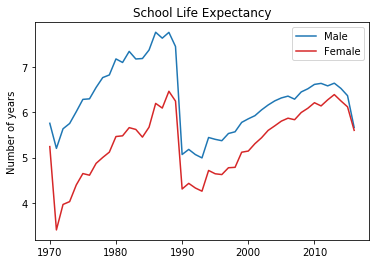

In [34]:
#For a better look in diff between the 2 genders
plt.plot(db_afr_ind_6.Year,db_afr_ind_6.Value,db_afr_ind_5.Year,db_afr_ind_5.Value,'tab:red')
plt.title('School Life Expectancy')
plt.legend(['Male','Female'])
plt.ylabel('Number of years')

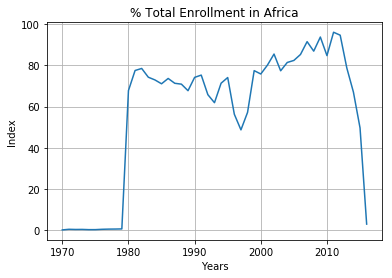

In [35]:
'''
Here we tried to look for a new attribute to see things better, the ratio of the enrolled people by the school aged people,
to look at the percentage of people going to school in Africa as a mean value, across the years.
'''

db_afr_ind_new = db_afr_indexes.copy()

nom_1 = db_afr_ind_new[db_afr_ind_new.Indicator == 'SE.PRM.ENRR.NUM.TO']

denom_1 = db_afr_ind_new[db_afr_ind_new.Indicator == 'SE.POP.PRM.NENR.TOT']

nom = nom_1['Value']
nom_f = nom.reset_index(drop=True)

denom = denom_1['Value']
denom_f = denom.reset_index(drop=True)

res = (nom_f/denom_f)*100

dates = range(1970,2017)

plt.plot(dates,res)
plt.xlabel('Years')
plt.ylabel('Index')
plt.title('% Total Enrollment in Africa')
plt.grid()
plt.show()

The big drop at the end is only due to unvailable data in recent years.. Information and Statistics may be not update
for many countries.

In [36]:
# Countries and regions Names?
countries_data.CountryName.unique()

array(['AFRICA', 'Cameroon', 'Central African Republic', 'Chad',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea', 'Gabon',
       'Sao Tome and Principe', 'Burundi', 'Comoros', 'Djibouti',
       'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Seychelles', 'Somalia',
       'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Algeria', 'Egypt',
       'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Angola', 'Botswana',
       'Lesotho', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique',
       'Namibia', 'South Africa', 'Swaziland', 'Zambia', 'Zimbabwe',
       'Benin', 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Niger',
       'Nigeria', 'Senegal', 'Sierra Leone', 'Togo'], dtype=object)

In [37]:
#From the list above, we see that multiple values are not needed (not only countries but also regions and set of countries
#that verify certain conditions are present)
#We will then eliminate this noisy data for these observations

location_afr = [9,18]
geo_data = os.path.join('./maps/', 'custom-afr-bibi.json')

chosen_year = 2010

Countries_Only = ['Cameroon', 'Central African Republic','Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Equatorial Guinea',
                 'Gabon', 'Sao Tome and Principe', 'Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia','Kenya',
                 'Rwanda', 'Seychelles', 'Somalia', 'South Sudan', 'Sudan', 'Tanzania', 'Uganda', 'Algeria', 'Egypt',
                 'Libya', 'Mauritania', 'Morocco', 'Tunisia', 'Angola', 'Botswana', 'Lesotho', 'Madagascar', 'Malawi',
                 'Mauritius', 'Mozambique', 'Namibia', 'South Africa', 'Swaziland', 'Zambia', 'Zimbabwe', 'Benin',
                 'Burkina Faso', 'Cape Verde', "Cote d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia',
                 'Mali', 'Niger', 'Nigeria', 'Senegal', 'Sierra Leone','Togo']

map_data = countries_data[['Country','CountryName','Year','Indicator','Value']].copy()

map_data = map_data[map_data.CountryName.isin(Countries_Only)]

map_data = map_data[map_data.Year == chosen_year]

map_data

,Country,CountryName,Year,Indicator,Value
51981,CMR,Cameroon,2010,FP.CPI.TOTL,1.288848e+02
52020,CMR,Cameroon,2010,FP.CPI.TOTL.ZG,1.279343e+00
52097,CMR,Cameroon,2010,GC.BAL.CASH.GD.CD,-3.229825e+08
52137,CMR,Cameroon,2010,GC.BAL.CASH.GD.ZS,-1.367266e+00
52197,CMR,Cameroon,2010,GC.REV.TOTL.GD.CD,3.850323e+09
...,...,...,...,...,...
2778702,GMB,Gambia,2010,DC.DAC.ODA.BIL.LUXL.CD,1.200000e+05
2778717,GMB,Gambia,2010,DC.DAC.NOF.BIL.LUXL.CD,1.200000e+05
2779406,GNB,Guinea-Bissau,2010,DC.DAC.ODA.BIL.AUSL.CD,1.600000e+05
2779418,GNB,Guinea-Bissau,2010,DC.DAC.NOF.BIL.AUSL.CD,1.600000e+05


### Here we will draw some maps to have a closer look at what these indexes values look like in each country,   for some specific year.

### We still haven't done the analysis for this part.

In [38]:
#1
map_data_1 = map_data[map_data.Indicator == 'SE.PRM.ENRR']

thresh = 105

def africa_colors_1(country):
    """Maps drachneya to drachneya etc.."""
    if not( map_data_1['Country'].str.contains(country).any()) : return '#00ff00'
    grrr = map_data_1.loc[map_data_1['Country'] == country,'Value'].values[0] > thresh
    if grrr :
        return '#0000ff'
    else:
        return '#ff0000'
    
    
m_afr_1 = folium.Map(location_afr, tiles='cartodbpositron', zoom_start=3)

folium.GeoJson(
    geo_data,
    style_function=lambda feature: {
        'fillColor': africa_colors_1(feature['id']),
        'color' : 'black',
        'weight' : 2,
        'dashArray' : '5, 5'
        }
    ).add_to(m_afr_1)

m_afr_1

In [39]:
m_afr_1 = folium.Map(location_afr, zoom_start=3)
m_afr_1.choropleth(geo_data=geo_data, data=map_data_1,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='aw jek')

m_afr_1

In [40]:
#2
map_data_2 = map_data[map_data.Indicator == 'SE.PRM.ENRL.TC.ZS']

m_afr_2 = folium.Map(location_afr, zoom_start=3)
m_afr_2.choropleth(geo_data=geo_data, data=map_data_2,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='aw jek')

m_afr_2

In [41]:
#3
map_data_3 = map_data[map_data.Indicator == 'SE.POP.PRM.NENR.TOT']

m_afr_3 = folium.Map(location_afr, zoom_start=3)
m_afr_3.choropleth(geo_data=geo_data, data=map_data_3,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_3

In [42]:
#4
map_data_4 = map_data[map_data.Indicator == 'SE.PRM.ENRR.NUM.TO']

m_afr_4 = folium.Map(location_afr, zoom_start=3)
m_afr_4.choropleth(geo_data=geo_data, data=map_data_4,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_4

In [43]:
#5
map_data_5 = map_data[map_data.Indicator == 'SE.YRS.SCHL.FE']

m_afr_5 = folium.Map(location_afr, zoom_start=3)
m_afr_5.choropleth(geo_data=geo_data, data=map_data_5,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_5

In [44]:
#6
map_data_6 = map_data[map_data.Indicator == 'SE.YRS.SCHL.MA']

m_afr_6 = folium.Map(location_afr, zoom_start=3)
m_afr_6.choropleth(geo_data=geo_data, data=map_data_6,
             columns=['Country', 'Value'],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name='aw jek')

m_afr_6

In [45]:
db_zero_pivot = pd.pivot_table(countries_data, values='Value', index=['Country', 'Year'], columns=['Indicator'])

In [46]:
development_indicators = ['SP.DYN.HDIV','SL.TLF.15UP.UEM','NY.GDP.PCAP.CD','FP.CPI.TOTL','CPI_S','SP.DYN.GIIV','SP.DYN.HPIV','SP.DYN.LE00.IN']
db_dev_inds = db_zero_pivot[development_indicators]

### Socio-Economic Growth part

In [47]:
countries_data_trimmed = countries_data[(countries_data.Year <= 2019) & (countries_data.Year >= 1990)]
countries_data_trimmed = countries_data_trimmed[countries_data_trimmed.CountryName.isin(Countries_Only)]
countries_data_trimmed.replace(to_replace=0.0, value=np.nan, inplace=True)
indicators_countries_trimmed = pd.pivot_table(countries_data_trimmed, values='Value', index=['Country','Year'], columns=['Indicator'])
indicators_countries_trimmed

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AGO     1990                NaN                NaN                NaN   
        1991                NaN                NaN                NaN   
        1992                NaN                NaN                NaN   
        1993                NaN                NaN                NaN   
        1994                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AGO     1990             NaN                 NaN                 NaN   
        1991             NaN                 NaN                 NaN   
        1992             NaN                 NaN                 NaN   
        1993             NaN                 NaN                 NaN   
        1994             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015             NaN                 2.7                2.50   
        2016             NaN                 2.7                2.75   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AGO     1990          NaN                   NaN                    NaN   
        1991          NaN                   NaN                    NaN   
        1992          NaN                   NaN                    NaN   
        1993          NaN                   NaN                    NaN   
        1994          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015          NaN               3.33333                2.16667   
        2016          NaN               3.66667                2.16667   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AGO     1990                   NaN  ...                NaN              NaN   
        1991                   NaN  ...                NaN              NaN   
        1992                   NaN  ...                NaN              NaN   
        1993                   NaN  ...                NaN              NaN   
        1994                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   NaN  ...       1.263811e+09       302.366614   
        2018                   NaN  ...       1.331340e+09       299.264516   
        2019                   NaN  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

In [48]:
ind_by_occurence_trimmed = countries_data_trimmed[['Year','Indicator']].groupby(['Indicator']).count()
ind_by_occurence_trimmed = ind_by_occurence_trimmed.reset_index() 
ind_by_occurence_trimmed.rename(columns={'Year':'Occurence'},inplace = True)
ind_by_occurence_trimmed.sort_values(by='Occurence', ascending=False, inplace = True)
ind_by_occurence_trimmed = ind_by_occurence_trimmed[ind_by_occurence_trimmed.Occurence >= 500]
ind_by_occurence_trimmed = ind_by_occurence_trimmed.merge(indicators_data[['Name','Code']],how='left',left_on='Indicator',right_on = 'Code')
ind_by_occurence_trimmed.drop(columns='Code',inplace=True)
ind_by_occurence_trimmed

,Indicator,Occurence,Name
0,SP.POP.0014.TO,1620,"Population ages 0-14, total"
1,SP.DYN.IFRT15-49,1620,% Women of Childbearing age 15-49 years
2,SP.POP.1549.MA.IN,1620,"Population ages 15-49, male"
3,SP.POP.1549.FE.ZS,1620,"Population ages 15-49, female (as % of total)"
4,SP.POP.1549.FE.IN,1620,"Population ages 15-49, female"
...,...,...,...
866,PS.DB.DL.DAY,502,Dealing with Licenses - Time (days)
867,DC.DAC.ODA.BIL.PRTL.CD,502,"Net ODA from DAC Donor - Portugal (Cur, US $)"
868,SE.XPD.TOTL.GN.ZS,502,"Public spending on education, total(% of GNI, ..."
869,PS.DB.CB.RR.IN,501,Closing a Business - Recovery rate (cents on t...


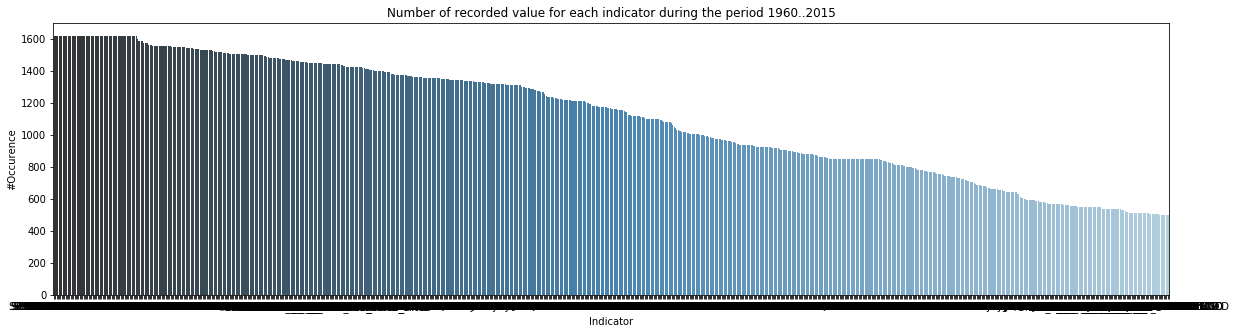

In [49]:
plt.figure(figsize=(20,5))
pl = sns.barplot(ind_by_occurence_trimmed.Indicator, y=ind_by_occurence_trimmed.Occurence, palette="Blues_d")
pl.set_title('Number of recorded value for each indicator during the period 1960..2015')
pl.set_ylabel('#Occurence')
plt.show()

## Social indicators
SP.DYN.LE00.IN : 	    	Life expectancy at birth, total (years)  
SP.RUR.TOTL.ZS : 	    	Rural population (% of total population)  
SP.URB.TOTL.IN.ZS : 		Urban population (% of total)  
SH.IMM.IBCG :           	Immunization coverage, BCG (% of one-year-old children)  
EG.ELC.CONS.TOTL.KH : 		Total Net Electricity Consumption  
SL.EMP.TOTL.SP.ZS: 		Employment to population ratio, 15+, total (%)  
SH.XPD.PUBL.ZS :	    	Public Expenditure on Health (as % of GDP)  
SP.DYN.HDIV	:   			Human development index (HDI)  

## Economic indicators
NY.GNP.PCAP.CD :	GNI per capita,(constant 2000 Prices, USD)  
AG.POP.EAC.TOT :	Economically active population ('000)  
FP.CPI.TOTL.ZG :	Inflation, consumer prices (annual %)   
AG.PRD.FOOD.XD :	Food production index (1999-2001 = 100)    
POP.EAC.FE.ZS :		Women's Share of Total Labor Force (%)  
SP.DYN.HPIV	: 		HUMAN POVERTY INDEX

## Education indicators 
SE.PRM.ENRR : school enrollment, primary (% gross)  
SE.SEC.ENRR : school enrollment, secondary (% gross)  
SE.TERT.ENRR : school enrollment, tertiary (% gross) ( school enrollment, tertiary total divided by school age population tertiary total)  
SE.YRS.SCHL.FE : school life expectancy female  
SE.YRS.SCHL.MA : school life expectancy male  
SE.PRM.ENRL.TC.ZS : pupil teacher ratio primary  
SE.SEC.ENRL.TC.ZS : Pupil-teacher ratio, secondary  
SE.XPD.TOTL.GN.ZS :	Public spending on education, total(% of GNI, UNESCO)

In [50]:
#Split train
indicators_countries_train = indicators_countries_trimmed[indicators_countries_trimmed.index.get_level_values(1) < 2020]

In [51]:
#fill nan
indicators_countries_filled = indicators_countries_train.copy()
indicators_countries_filled = indicators_countries_filled.groupby('Country').fillna(method='ffill', axis=0)
indicators_countries_filled = indicators_countries_filled.groupby('Country').fillna(method='bfill', axis=0)
indicators_countries_filled

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AGO     1990                5.5                5.0                5.0   
        1991                5.5                5.0                5.0   
        1992                5.5                5.0                5.0   
        1993                5.5                5.0                5.0   
        1994                5.5                5.0                5.0   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                2.5                2.0                3.0   
        2018                2.5                2.0                3.0   
        2019                2.5                2.0                3.0   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AGO     1990            3.50                 3.0                1.75   
        1991            3.50                 3.0                1.75   
        1992            3.50                 3.0                1.75   
        1993            3.50                 3.0                1.75   
        1994            3.50                 3.0                1.75   
...                      ...                 ...                 ...   
ZWE     2015            1.83                 2.7                2.50   
        2016            1.83                 2.7                2.75   
        2017            1.83                 2.7                2.75   
        2018            1.83                 2.7                2.75   
        2019            1.83                 2.7                2.75   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AGO     1990         40.0               3.83333                3.50000   
        1991         40.0               3.83333                3.50000   
        1992         40.0               3.83333                3.50000   
        1993         40.0               3.83333                3.50000   
        1994         40.0               3.83333                3.50000   
...                   ...                   ...                    ...   
ZWE     2015         40.0               3.33333                2.16667   
        2016         40.0               3.66667                2.16667   
        2017         40.0               3.66667                2.16667   
        2018         40.0               3.66667                2.16667   
        2019         40.0               3.66667                2.16667   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AGO     1990                   4.0  ...       3.501917e+08        38.579437   
        1991                   4.0  ...       3.501917e+08        38.579437   
        1992                   4.0  ...       3.501917e+08        38.579437   
        1993                   4.0  ...       3.501917e+08        38.579437   
        1994                   4.0  ...       3.501917e+08        38.579437   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   2.5  ...       1.263811e+09       302.366614   
        2018                   2.5  ...       1.331340e+09       299.264516   
        2019                   2.5  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

In [52]:
indicators_countries_interpolated = indicators_countries_train.copy()
indicators_countries_interpolated = indicators_countries_interpolated.groupby('Country').apply(lambda group: group.interpolate(method='linear',axis=0,limit_direction='both', limit_area='inside'))
indicators_countries_interpolated

Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
AGO     1990                NaN                NaN                NaN   
        1991                NaN                NaN                NaN   
        1992                NaN                NaN                NaN   
        1993                NaN                NaN                NaN   
        1994                NaN                NaN                NaN   
...                         ...                ...                ...   
ZWE     2015                2.5                2.5                3.0   
        2016                2.5                2.0                3.0   
        2017                NaN                NaN                NaN   
        2018                NaN                NaN                NaN   
        2019                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
AGO     1990             NaN                 NaN                 NaN   
        1991             NaN                 NaN                 NaN   
        1992             NaN                 NaN                 NaN   
        1993             NaN                 NaN                 NaN   
        1994             NaN                 NaN                 NaN   
...                      ...                 ...                 ...   
ZWE     2015             NaN                 2.7                2.50   
        2016             NaN                 2.7                2.75   
        2017             NaN                 NaN                 NaN   
        2018             NaN                 NaN                 NaN   
        2019             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
AGO     1990          NaN                   NaN                    NaN   
        1991          NaN                   NaN                    NaN   
        1992          NaN                   NaN                    NaN   
        1993          NaN                   NaN                    NaN   
        1994          NaN                   NaN                    NaN   
...                   ...                   ...                    ...   
ZWE     2015          NaN               3.33333                2.16667   
        2016          NaN               3.66667                2.16667   
        2017          NaN                   NaN                    NaN   
        2018          NaN                   NaN                    NaN   
        2019          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
AGO     1990                   NaN  ...                NaN              NaN   
        1991                   NaN  ...                NaN              NaN   
        1992                   NaN  ...                NaN              NaN   
        1993                   NaN  ...                NaN              NaN   
        1994                   NaN  ...                NaN              NaN   
...                            ...  ...                ...              ...   
ZWE     2015                   2.5  ...       1.260197e+09       286.796901   
        2016                   2.5  ...       1.319484e+09       280.518802   
        2017                   NaN  ...       1.263811e+09       302.366614   
        2018                   NaN  ...       1.331340e+09       299.264516   
        2019                   NaN  ...       1.410437e+09       296.748918   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                             

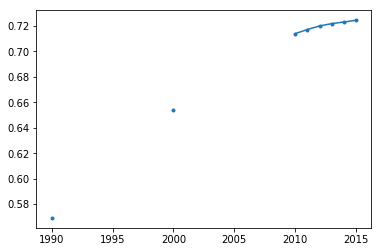

In [53]:
plt.plot(indicators_countries_train['SP.DYN.HDIV'].loc['TUN'],marker='o',ms=3)

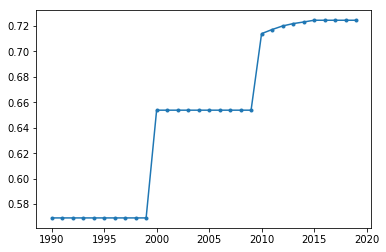

In [54]:
plt.plot(indicators_countries_filled['SP.DYN.HDIV'].loc['TUN'],marker='o',ms=3)

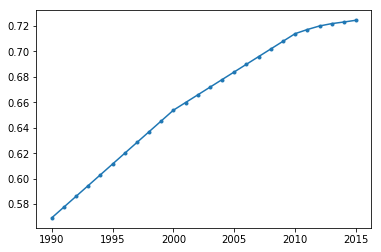

In [55]:
plt.plot(indicators_countries_interpolated['SP.DYN.HDIV'].loc['TUN'],marker='o',ms=3)

In [56]:
indicators_countries_train['SP.DYN.HDIV'].loc['TUN',1990]

0.569151441180838

In [57]:
# education_indicators = ['SE.PRM.ENRR.NUM.TO','SE.SEC.ENRR.NUM.TO','SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS']
#education_indicators = ['SE.PRM.NENR','SE.SEC.ENRR','SE.TERT.ENRR','SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS','SE.SEC.ENRL.TC.ZS','SE.XPD.BUDG.ZS']
education_indicators = ['SE.PRM.NENR','SE.SEC.ENRR','SE.TERT.ENRR','SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS','SE.SEC.ENRL.TC.ZS','SE.XPD.TOTL.GN.ZS']
# Compute  SE.TERT.ENRR by its definition:
enrollment_tertiary_total = 'SE.TERT.ENRR.NUM.TOT'
population_tertiary_total = 'SE.POP.TERT.NENR.TOT'
enrollment_tertiary_percentage = 'SE.TERT.ENRR'
indicators_countries_interpolated[enrollment_tertiary_percentage] = indicators_countries_interpolated[enrollment_tertiary_total] / indicators_countries_interpolated[population_tertiary_total]

In [58]:
# compare number of occurence for indicators before and after interpolation
ind_by_occurence_interpolated = pd.DataFrame(indicators_countries_interpolated.notna().sum(),columns=['Occurence_after_interpolation']).reset_index()
ind_by_occurence_trimmed = ind_by_occurence_trimmed.merge(ind_by_occurence_interpolated,how='left',left_on='Indicator',right_on = 'Indicator')
ind_by_occurence_trimmed

,Indicator,Occurence,Name,Occurence_after_interpolation
0,SP.POP.0014.TO,1620,"Population ages 0-14, total",1620.0
1,SP.DYN.IFRT15-49,1620,% Women of Childbearing age 15-49 years,1620.0
2,SP.POP.1549.MA.IN,1620,"Population ages 15-49, male",1620.0
3,SP.POP.1549.FE.ZS,1620,"Population ages 15-49, female (as % of total)",1620.0
4,SP.POP.1549.FE.IN,1620,"Population ages 15-49, female",1620.0
...,...,...,...,...
866,PS.DB.DL.DAY,502,Dealing with Licenses - Time (days),502.0
867,DC.DAC.ODA.BIL.PRTL.CD,502,"Net ODA from DAC Donor - Portugal (Cur, US $)",672.0
868,SE.XPD.TOTL.GN.ZS,502,"Public spending on education, total(% of GNI, ...",750.0
869,PS.DB.CB.RR.IN,501,Closing a Business - Recovery rate (cents on t...,488.0


In [59]:
# save to file
ind_by_occurence_trimmed.to_csv('./data/Indicators_not_nan.csv', sep='\t')

# New Y indicators: 

* employment_indicator : Employment to population ratio, 15+, total (%) scaled to 0-1
* health_indicator : life expectancy at birth scaled to 0-1 (0 is 20 and 1 is 85)
* income_indicator : GNI per capita scaled to 0-1 (0 is 100 or lower and 1 is 7500 or lower)
* gender_equality_indicator: Women's Share of Total Labor Force (%)  scaled to 0-1 (0 is 0 or 100 and 1 is 50)

## Combined target indicator
development_indicator is the geometric average of the previously-cited Y indicators

In [60]:
development_indicators = ['employment','health','income','gender_equality']
# Scale development indicators
df_development_indicators = pd.DataFrame(index = indicators_countries_interpolated.index,columns=development_indicators)
df_development_indicators['employment'] = indicators_countries_interpolated['SL.EMP.TOTL.SP.ZS']/100
df_development_indicators['health'] = (indicators_countries_interpolated['SP.DYN.LE00.IN']-20)/(85-20)
df_development_indicators['income'] = indicators_countries_interpolated['NY.GNP.PCAP.CD'].apply(lambda x: np.sqrt(np.log(x/100)/np.log(7500/100)))
df_development_indicators['gender_equality'] = indicators_countries_interpolated['POP.EAC.FE.ZS'].apply(lambda x: (1 - abs(x-50)/50))
from scipy import stats
y_indicator = 'development'
# Compute development indicator as geometric mean of previous indicators
df_development_indicators[y_indicator] = stats.gmean(df_development_indicators,axis=1)
indicators_countries_interpolated[y_indicator] = df_development_indicators[y_indicator]
df_development_indicators.dropna()

employment    health    income  gender_equality  development
Country Year                                                              
AGO     1991       0.650  0.326477  0.702015            0.748     0.577768
        1992       0.653  0.328138  0.583324            0.734     0.550356
        1993       0.662  0.330692  0.494547            0.692     0.523177
        1994       0.659  0.334400  0.368080            0.694     0.487095
        1995       0.656  0.339585  0.502832            0.702     0.529545
...                  ...       ...       ...              ...          ...
ZWE     2012       0.783  0.518046  0.709724            0.448     0.599273
        2013       0.783  0.548708  0.718684            0.444     0.608494
        2014       0.782  0.577446  0.722105            0.440     0.615450
        2015       0.784  0.603077  0.723782            0.438     0.622218
        2016       0.783  0.624646  0.720406            0.436     0.626058

[1270 rows x 5 columns]

In [61]:
df_development_indicators.isna().sum()

employment         112
health               0
income             271
gender_equality     60
development        350
dtype: int64

In [62]:
#y_indicator = 'NY.GDP.PCAP.KD' #GDP per capita
#y_indicator = 'SE.XPD.BUDG.ZS' #Public expenditure on Education
#y_indicator = 'POP.EAC.FE.ZS' # percentage of women participation in workforce
#y_indicator = 'SL.EMP.TOTL.SP.ZS' # employment to population ratio
#y_indicator = 'SP.DYN.HDIV' # human development index
X_education_train = indicators_countries_interpolated[education_indicators + [y_indicator]].dropna()
Y_education_train = X_education_train[y_indicator]
X_education_train.drop(columns = y_indicator,inplace=True)

In [63]:
scaler = StandardScaler().fit(X_education_train)
X_education_train_scaled = scaler.transform(X_education_train)
X_education_train_scaled = pd.DataFrame(X_education_train_scaled, columns = X_education_train.columns)
rr = RidgeCV(alphas=np.arange(1,4000),  scoring='neg_mean_squared_error', store_cv_values=True)
rr.fit(X_education_train_scaled,Y_education_train)
rr.alpha_

2

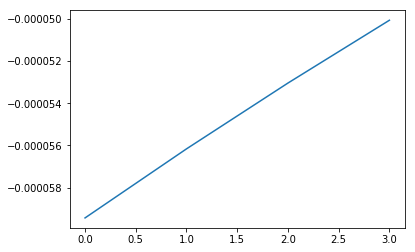

In [64]:
regression_scores = rr.cv_values_.mean(axis=0)
plt.plot(regression_scores[range(2*rr.alpha_)])

In [65]:
coefs = pd.DataFrame(rr.coef_,index = X_education_train.columns, columns = ['weight'])
print('Ridge regression model with leave-one-out cross-validation trained on '+str(len(Y_education_train))+' data points outputs the following weights:')
coefs

Ridge regression model with leave-one-out cross-validation trained on 537 data points outputs the following weights:


,weight
Indicator,
SE.PRM.NENR,0.018070
SE.SEC.ENRR,0.082126
SE.TERT.ENRR,-0.034402
SE.YRS.SCHL.FE,-0.040904
SE.YRS.SCHL.MA,0.010010
SE.PRM.ENRL.TC.ZS,-0.003813
SE.SEC.ENRL.TC.ZS,-0.004427
SE.XPD.TOTL.GN.ZS,-0.013035


In [66]:
indicators_countries_interpolated[education_indicators + [y_indicator]].dropna().corr()

Indicator,SE.PRM.NENR,SE.SEC.ENRR,SE.TERT.ENRR,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA,SE.PRM.ENRL.TC.ZS,SE.SEC.ENRL.TC.ZS,SE.XPD.TOTL.GN.ZS,development
Indicator,,,,,,,,,
SE.PRM.NENR,1.000000,0.716284,0.536131,0.843405,0.830240,-0.292221,-0.264372,0.319509,0.383077
SE.SEC.ENRR,0.716284,1.000000,0.807970,0.578486,0.508753,-0.640885,-0.389414,0.331257,0.614657
SE.TERT.ENRR,0.536131,0.807970,1.000000,0.272910,0.221130,-0.561003,-0.377974,0.120197,0.437903
SE.YRS.SCHL.FE,0.843405,0.578486,0.272910,1.000000,0.946013,-0.224510,-0.250157,0.415280,0.230522
SE.YRS.SCHL.MA,0.830240,0.508753,0.221130,0.946013,1.000000,-0.089712,-0.150594,0.347070,0.214032
SE.PRM.ENRL.TC.ZS,-0.292221,-0.640885,-0.561003,-0.224510,-0.089712,1.000000,0.732564,-0.307876,-0.420000
SE.SEC.ENRL.TC.ZS,-0.264372,-0.389414,-0.377974,-0.250157,-0.150594,0.732564,1.000000,-0.229185,-0.242538
SE.XPD.TOTL.GN.ZS,0.319509,0.331257,0.120197,0.415280,0.347070,-0.307876,-0.229185,1.000000,0.055805
development,0.383077,0.614657,0.437903,0.230522,0.214032,-0.420000,-0.242538,0.055805,1.000000


In [67]:
correlations = indicators_countries_interpolated[education_indicators + [y_indicator]].dropna().corr().iloc[-1][:-1]
correlations = correlations.sort_values(ascending=False)
correlations = pd.DataFrame(correlations).T
correlations

Indicator,SE.SEC.ENRR,SE.TERT.ENRR,SE.PRM.NENR,SE.YRS.SCHL.FE,SE.YRS.SCHL.MA,SE.XPD.TOTL.GN.ZS,SE.SEC.ENRL.TC.ZS,SE.PRM.ENRL.TC.ZS
development,0.614657,0.437903,0.383077,0.230522,0.214032,0.055805,-0.242538,-0.42


We can see that our education indicators are highly correlated with the output indicator which gives us an idea about the impact of education indicators on development.

In [68]:
def plot_map(indicator, year, df_country_year,save_name=None):
    '''
    Plots a map with chosen indicator for all countries during a specified year from df_country_year 
    '''
    location_afr = [9,18]
    geo_data = os.path.join('./maps/', 'custom-afr-bibi.json')
    df_reset = df_country_year[df_country_year.index.get_level_values(1) == year][indicator].reset_index()
    m_afr = folium.Map(location_afr, zoom_start=3)
    m_afr.choropleth(geo_data=geo_data, data=df_reset,
             columns=['Country', indicator],
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.4,
             legend_name=indicator)
    if not(save_name is None):
        m_afr.save('./maps/'+save_name+'.html')
    return m_afr

In [69]:
# Prepare test data
## make a forward padding of missing data to take most recent available value
year_test = 2019
indictors_countries_test = indicators_countries_interpolated.copy()
#indictors_countries_test = indicators_countries_trimmed.copy()
indictors_countries_test.update(indictors_countries_test.groupby('Country').ffill())
indictors_countries_test = indictors_countries_test[indictors_countries_test.index.get_level_values(1) == year_test]

## Scale certain education indicators by total population number
indictors_countries_test[enrollment_tertiary_percentage] = indictors_countries_test[enrollment_tertiary_total] / indictors_countries_test[population_tertiary_total]

## Extract x & y test
X_education_test = indictors_countries_test[education_indicators + [y_indicator]].dropna()
Y_education_test = pd.DataFrame(X_education_test[y_indicator], index = X_education_test.index,columns = [y_indicator])
X_education_test = X_education_test[education_indicators]
## Normalize to std =1 & mean=0
scaler = StandardScaler().fit(X_education_test)
X_education_test_scaled = scaler.transform(X_education_test)
X_education_test_scaled = pd.DataFrame(X_education_test_scaled, columns = X_education_test.columns)
# predict output
Y_education_pred = pd.DataFrame(rr.predict(X_education_test_scaled), index = Y_education_test.index,columns = [y_indicator])
#regression_output = pd.DataFrame({Y_education_pred[y_indicator],Y_education_test[y_indicator]},columns = ['prediction','actual'])
regression_output = Y_education_pred.merge(Y_education_test,left_index = True,right_index = True,suffixes = ('_prediction','_actual'))
regression_output['absolute error'] = 100*abs(regression_output[y_indicator+'_prediction'] - regression_output[y_indicator+'_actual'])/regression_output[y_indicator+'_actual']
regression_output

,,development_prediction,development_actual,absolute error
Country,Year,,,
AGO,2019,0.537907,0.697892,22.923966
BDI,2019,0.540458,0.518325,4.270054
BEN,2019,0.587908,0.654440,10.166230
BFA,2019,0.553106,0.622439,11.138823
BWA,2019,0.600335,0.692846,13.352383
CAF,2019,0.510677,0.581543,12.185857
CIV,2019,0.587081,0.690702,15.002358
CMR,2019,0.605137,0.650066,6.911467
COG,2019,0.571074,0.685051,16.637792


In [70]:
#error
m_afr_y_error = plot_map('absolute error',year_test,regression_output)
m_afr_y_error

In [71]:
#y_test
m_afr_y_test = plot_map(y_indicator,year_test,Y_education_test)
m_afr_y_test

In [72]:
#y_pred
m_afr_y_pred = plot_map(y_indicator,year_test,Y_education_pred)
m_afr_y_pred

## Remarks:
* In all the economic indicators, the weights of the education indicators *SE.YRS.SCHL.FE* (School Life Expectancy, female (year)) and *SE.YRS.SCHL.MA* (School Life Expectancy, male (year)) are always positive and negative, respectively, which indicates that economic development correlates highly with societies that have better gender equality.

# African Success story: Ethiopia

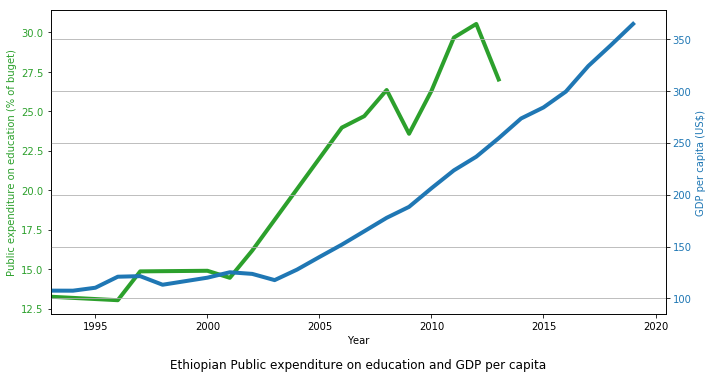

In [73]:
country_code = 'ETH'
indicators_success_story = indicators_countries_interpolated.loc[country_code]

# Create some mock data
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:green'
ax1.set_xlabel('Year')
ax1.set_ylabel('Public expenditure on education (% of buget)', color=color)  # we already handled the x-label with ax1
ax1.plot(indicators_success_story['SE.XPD.BUDG.ZS'], color=color, linewidth=4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'

ax2.set_ylabel('GDP per capita (US$)', color=color)
ax2.plot(indicators_success_story['NY.GDP.PCAP.KD'], color=color, linewidth=4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True)
plt.xlim(left = 1993)
plt.title('Ethiopian Public expenditure on education and GDP per capita',y=-0.2)
plt.savefig('./graphs/Ethiopia-graph.png')
plt.show()


Ethiopia is one of the fastest growing economies in the world. In 2000, its GDP per capita was less than 150 USD/capita. It exceeds 350 USD/capita in 2019. 
Ethiopia invested heavily in education in the last two decades; more than 30% of its budget in 2012 was invested towards building schools and improving its people's education levels. This endeavour was immediately followed by an incredible increase in economic development indicators. Once they have ensured a secure education system and enough access to education for its people, Ethiopian governments were able to refocus their expenses towards securing other objectives, which is explained by the drop in the percentage of budget directed to education after 2013.

# African Success story: Rwanda

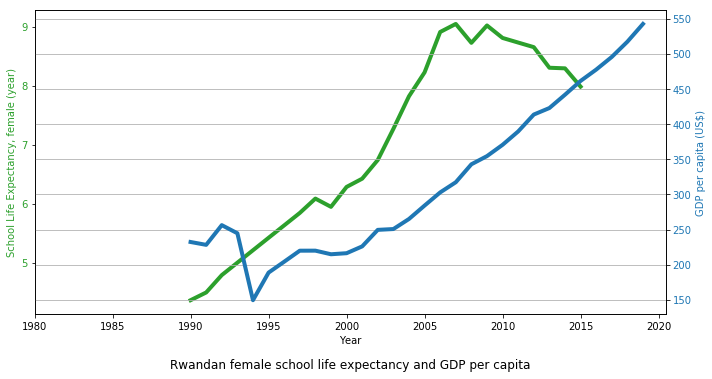

In [74]:
y_women_labour = 'POP.EAC.FE.ZS' # % of women in the labour force
y_women_parliament = 'SG.GEN.PARL.ZS' # Proportion of seats held by women in national parliament (%)
y_women_school_expectency = 'SE.YRS.SCHL.FE' # School Life Expectancy, female (year)
y_HDI = 'SP.DYN.HDIV'
country_code = 'RWA'
indicators_success_story = indicators_countries_interpolated.loc[country_code]

# Create some mock data
fig, ax1 = plt.subplots(figsize = (10,5))

color = 'tab:green'
ax1.set_xlabel('Year')
ax1.set_ylabel('School Life Expectancy, female (year)', color=color)
ax1.plot(indicators_success_story[y_women_school_expectency], color=color, linewidth=4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('GDP per capita (US$)', color=color)  # we already handled the x-label with ax1
ax2.plot(indicators_success_story['NY.GDP.PCAP.KD'], color=color, linewidth=4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True)
plt.xlim(left = 1980)
plt.title('Rwandan female school life expectancy and GDP per capita',y=-0.2)
plt.savefig('./graphs/Rwanda-graph.png')
plt.show()

Rwanda, a country in central Africa, received its independence from Belgium in 1962. Since then, its history was troubled with internal conflicts between its different ethnic groups, mainly between the Hutu and the Tutsi. These tensions resulted in a civil war between 1990 and 1993 that took the lives of 60'000 people. A year later, in 1994, Rwandan leaders, mainly Hutu, commited one of the biggest human atrocities in the last decade of the 20th century; the Rwandan genocide. The UNO estimates that the lives of 800'000 Rwandans were taken by the ravages, majoritarily from the Tutsi. 

It took until after 2003 for Rwanda to adopt a constitution, representing its people's will and reach political stability. Since then, Rwanda attained considerable levels of economical development with more than 6% yearly growth rate, which granted it the reputation of being Africa's Singapore. This due to certain major political reforms such as facilitating the creation of new businesses and women.

In fact, the genocide's victims were predominantly men, creating a huge gap between the country's male and female population. In consequence, women gained a much more important role in the Rwandan society. They have better access to education and can take leadership positions and contribute better to the economy. This corroborates with our finding on the relationship between women access to education and economical development.

# African Success story: Botswana

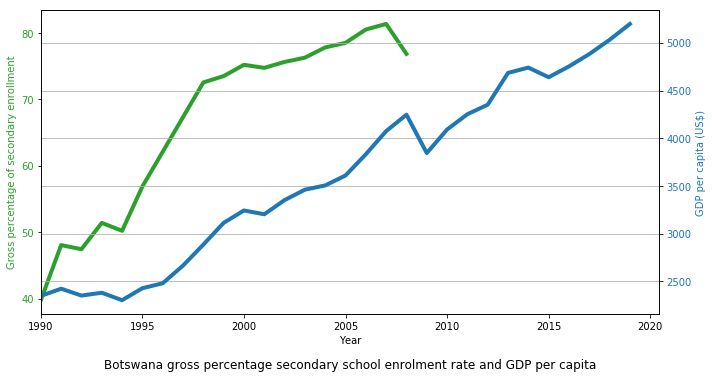

In [75]:
country_code = 'BWA'
indicators_success_story = indicators_countries_interpolated.loc[country_code]

# Create some mock data
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:green'
ax1.set_xlabel('Year')
ax1.set_ylabel('Gross percentage of secondary enrollment', color=color)  # we already handled the x-label with ax1
ax1.plot(indicators_success_story['SE.SEC.ENRR'], color=color, linewidth=4)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'

ax2.set_ylabel('GDP per capita (US$)', color=color)
ax2.plot(indicators_success_story['NY.GDP.PCAP.KD'], color=color, linewidth=4)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid(True)
plt.xlim(left = 1990)
plt.title('Botswana gross percentage secondary school enrolment rate and GDP per capita',y=-0.2)
plt.savefig('./graphs/Botswana-graph.png')
plt.show()


In [76]:
indicators_countries_interpolated['NY.GDP.PCAP.KD'].loc['BWA']

Year
1990    2348.267270
1991    2423.967654
1992    2352.078110
1993    2381.712255
1994    2303.462570
1995    2429.200136
1996    2481.077689
1997    2666.179703
1998    2885.991844
1999    3113.846617
2000    3243.603767
2001    3203.844987
2002    3352.393771
2003    3461.410879
2004    3506.033664
2005    3610.228195
2006    3832.459347
2007    4075.070050
2008    4247.081126
2009    3845.199435
2010    4091.686627
2011    4252.213539
2012    4351.914182
2013    4685.066387
2014    4740.629839
2015    4639.613169
2016    4752.811133
2017    4881.982925
2018    5031.501533
2019    5197.986326
Name: NY.GDP.PCAP.KD, dtype: float64

When gaining its independence in 1966, Botswana was the second poorest country in the world. It had no hospitals, only 3 missionary schools and no universities.
In the 20th century, Botswana faced two major threats that took extreme effort to surpass. The first one was a major drought that had a considerable impact on the country's food security. With global warming effects getting more and more prominent, Botswana to this day still facing drought and water insufficience. One decade later, in the 1990s, an AIDS pandemic spread into Botswana leading to, in 2000, a rate of 26.9% of the total adult population to be living with AIDS.

Botswana is currently one of the most developed African countries with a Human Development Index of 0.697687.
It has one of the highest GNI per capita in the continent of 6610.0 USD/capita. Botswana is also the last standing democracy in Africa and ranks in the first 75 percentile in terms of the "World. Governance Ind.: Control of Corruption"

In [77]:
# fastest growing countries in Africa
GDP_growth = 'NY.GDP.MKTP.KD.ZG'
recent_growth = pd.DataFrame(indicators_countries_trimmed[indicators_countries_trimmed.index.get_level_values(1) == 2019][GDP_growth],columns = [GDP_growth]).sort_values(GDP_growth,ascending=False)
recent_growth.head(10)

,,NY.GDP.MKTP.KD.ZG
Country,Year,
ETH,2019,8.520608
CIV,2019,7.794777
RWA,2019,7.246463
SEN,2019,7.025372
DJI,2019,6.927191
TZA,2019,6.925716
BEN,2019,6.492920
SLE,2019,6.470050
GIN,2019,6.306246


In [78]:
#growth map
m_afr_growth= plot_map(GDP_growth,2019,indicators_countries_trimmed)
m_afr_growth

# Fast growing economies:
Countries achieving considerably high GDP growth rate, reaching values higher than 6% for more than 10 countries in the latest recorded values. The average growth rate in 2019 of the african countries is 4.2%.  
Ethiopia leads the list with 8.5% GDP growth rate.  
World average in 2019 is 3.01%(source= https://www.statista.com/statistics/273951/growth-of-the-global-gross-domestic-product-gdp/)  
In 2015, out of the top 10 fastest growing countries in the world, 5 of them were African.  

# Comparing corelation of education indicators with economic indices vs social indices

In [79]:
country_code = np.array(indicators_countries_interpolated.index.get_level_values(0).unique())
country_code

array(['AGO', 'BDI', 'BEN', 'BFA', 'BWA', 'CAF', 'CIV', 'CMR', 'COG',
       'COM', 'CPV', 'DJI', 'DZA', 'EGY', 'ERI', 'ETH', 'GAB', 'GHA',
       'GIN', 'GMB', 'GNB', 'GNQ', 'KEN', 'LBR', 'LBY', 'LSO', 'MAR',
       'MDG', 'MLI', 'MOZ', 'MRT', 'MUS', 'MWI', 'NAM', 'NER', 'NGA',
       'RWA', 'SDN', 'SEN', 'SLE', 'SOM', 'SSD', 'STP', 'SWZ', 'SYC',
       'TCD', 'TGO', 'TUN', 'TZA', 'UGA', 'ZAF', 'ZAR', 'ZMB', 'ZWE'],
      dtype=object)

In [80]:
indicators_tunisia_interpolated = indicators_countries_interpolated[indicators_countries_interpolated\
                                                                   .index.get_level_values(0)=='TUN']
social_indicators = ['SP.URB.TOTL.IN.ZS','SL.EMP.TOTL.SP.ZS','SE.XPD.BUDG.ZS']
economic_indicators = ['NY.GDP.PCAP.KD','AG.POP.EAC.TOT','POP.EAC.FE.ZS']
educational_indicators = ['SE.PRM.ENRR.NUM.TO','SE.SEC.ENRR.NUM.TO',\
                          'SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS']

indicators_tunisia_interpolated = indicators_tunisia_interpolated[educational_indicators+\
                                                                  economic_indicators+\
                                                                  social_indicators]


In [81]:
indicators_tunisia_interpolated.head(5)

Indicator     SE.PRM.ENRR.NUM.TO  SE.SEC.ENRR.NUM.TO  SE.YRS.SCHL.FE  \
Country Year                                                           
TUN     1990           1376519.0            546953.0         6.42365   
        1991           1405665.0            564540.0         6.49868   
        1992           1426215.0            589674.0         6.52909   
        1993           1440960.0            639403.0         6.54438   
        1994           1476329.0            717156.0         6.65725   

Indicator     SE.YRS.SCHL.MA  SE.PRM.ENRL.TC.ZS  NY.GDP.PCAP.KD  \
Country Year                                                      
TUN     1990         7.45340        2968.811198     1489.978045   
        1991         7.43815        2777.500049     1514.122684   
        1992         7.38176        2640.503212     1597.122821   
        1993         7.29101        2619.308164     1598.372898   
        1994         7.34105        2629.071838     1617.597475   

Indicator     AG.POP.EAC.TOT  POP.EAC.FE.ZS  SP.URB.TOTL.IN.ZS  \
Country Year                                                     
TUN     1990       2490000.0           20.5          57.259604   
        1991       2571000.0           20.9          58.069133   
        1992       2657000.0           21.3          58.842788   
        1993       2746000.0           21.7          59.586986   
        1994       2834000.0           22.1          60.243128   

Indicator     SL.EMP.TOTL.SP.ZS  SE.XPD.BUDG.ZS  
Country Year                                     
TUN     1990                NaN             NaN  
        1991               40.8             NaN  
        1992               40.6        21.41026  
        1993               40.4        22.05631  
        1994               40.1        22.28969

In [82]:
#1992/2013
#indicators_tunisia_interpolated = indicators_tunisia_interpolated.dropna()
indicators_tunisia_interpolated.head()

Indicator     SE.PRM.ENRR.NUM.TO  SE.SEC.ENRR.NUM.TO  SE.YRS.SCHL.FE  \
Country Year                                                           
TUN     1990           1376519.0            546953.0         6.42365   
        1991           1405665.0            564540.0         6.49868   
        1992           1426215.0            589674.0         6.52909   
        1993           1440960.0            639403.0         6.54438   
        1994           1476329.0            717156.0         6.65725   

Indicator     SE.YRS.SCHL.MA  SE.PRM.ENRL.TC.ZS  NY.GDP.PCAP.KD  \
Country Year                                                      
TUN     1990         7.45340        2968.811198     1489.978045   
        1991         7.43815        2777.500049     1514.122684   
        1992         7.38176        2640.503212     1597.122821   
        1993         7.29101        2619.308164     1598.372898   
        1994         7.34105        2629.071838     1617.597475   

Indicator     AG.POP.EAC.TOT  POP.EAC.FE.ZS  SP.URB.TOTL.IN.ZS  \
Country Year                                                     
TUN     1990       2490000.0           20.5          57.259604   
        1991       2571000.0           20.9          58.069133   
        1992       2657000.0           21.3          58.842788   
        1993       2746000.0           21.7          59.586986   
        1994       2834000.0           22.1          60.243128   

Indicator     SL.EMP.TOTL.SP.ZS  SE.XPD.BUDG.ZS  
Country Year                                     
TUN     1990                NaN             NaN  
        1991               40.8             NaN  
        1992               40.6        21.41026  
        1993               40.4        22.05631  
        1994               40.1        22.28969

In [83]:
educational_corr = np.zeros((len(educational_indicators),2)) 
#social_corr = np.zeros(len(social_indicators)) 
#economic_corr = np.zeros(len(economic_indicators)) 
for i, x in enumerate(educational_indicators):
    for y in social_indicators:
        educational_corr[i,0] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')
                                                                        
    educational_corr[i,0] = educational_corr[i,0]/len(social_indicators)    
    for y in economic_indicators:
        educational_corr[i,1] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')
                                                                        
    educational_corr[i,1] = educational_corr[i,1]/len(economic_indicators)
    
    
    

In [84]:
educational_corr

array([[-0.25846493, -0.83739072],
       [ 0.28308287,  0.66093014],
       [-0.14003794, -0.12596933],
       [-0.34109997, -0.85494623],
       [-0.35135795, -0.97873793]])

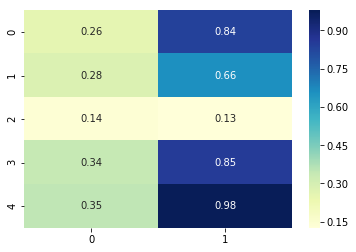

In [85]:
sns.heatmap(np.abs(educational_corr), annot=True, cmap="YlGnBu")

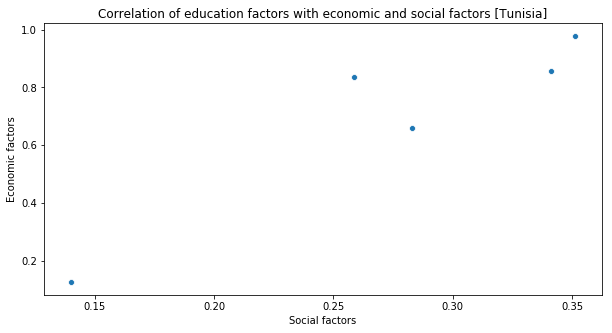

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(np.abs(educational_corr[:,0]), np.abs(educational_corr[:,1]))
ax.set_xlabel('Social factors')
ax.set_ylabel('Economic factors')
ax.set_title('Correlation of education factors with economic and social factors [Tunisia]')
plt.show()

In [87]:
educational_corr = np.zeros((len(country_code),len(educational_indicators),2)) 
for j, country in enumerate(country_code):
    indicators_tunisia_interpolated = indicators_countries_interpolated[indicators_countries_interpolated\
                                                                   .index.get_level_values(0)==country]
    social_indicators = ['SP.URB.TOTL.IN.ZS','SL.EMP.TOTL.SP.ZS','SE.XPD.BUDG.ZS']
    economic_indicators = ['NY.GDP.PCAP.KD','AG.POP.EAC.TOT','POP.EAC.FE.ZS']
    educational_indicators = ['SE.PRM.ENRR.NUM.TO','SE.SEC.ENRR.NUM.TO',\
                              'SE.YRS.SCHL.FE','SE.YRS.SCHL.MA','SE.PRM.ENRL.TC.ZS']

    indicators_tunisia_interpolated = indicators_tunisia_interpolated[educational_indicators+\
                                                                      economic_indicators+\
                                                                      social_indicators]
    '''indicators_tunisia_interpolated = indicators_tunisia_interpolated[indicators_tunisia_interpolated\
                                                                     .index.get_level_values(1)>=1992]
    indicators_tunisia_interpolated = indicators_tunisia_interpolated[indicators_tunisia_interpolated\
                                                                     .index.get_level_values(1)<=2013]'''
    indicators_tunisia_interpolated


    for i, x in enumerate(educational_indicators):
        for y in social_indicators:
            educational_corr[j,i,0] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')

        educational_corr[j,i,0] = educational_corr[j,i,0]/len(social_indicators)    
        for y in economic_indicators:
            educational_corr[j,i,1] += indicators_tunisia_interpolated[x].corr(indicators_tunisia_interpolated[y],method='spearman')

        educational_corr[j,i,1] = educational_corr[j,i,1]/len(economic_indicators)
    

In [88]:
educational_corr.shape

(54, 5, 2)

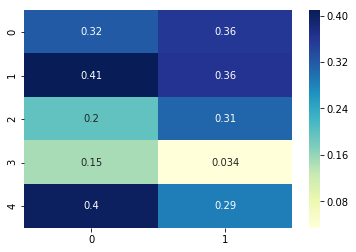

In [89]:
sns.heatmap(np.abs(educational_corr[9,:,:]), annot=True, cmap="YlGnBu")